In [1]:
import numpy as np
import torch

In [2]:
from scnn import SNN
from scnn.optim import RAdam
from utils import print_and_plot_accuracy_metrics

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from scnn.default_configs import *

time_expector = TimeExpector()

In [3]:
batch_size = 32
nb_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

test_run = True
if test_run:
    print('[WARNING] : This is test run.')

[WARNING] : This is test run.


In [4]:
# FIXME
my_laptop = True
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    if test_run:
        trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=60
    )

# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])
for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

pre-processing dataset: 21
pre-processing dataset: 21


In [5]:
class DenseWithoutSynapse(torch.nn.Module):
    IS_CONV = False
    IS_SPIKING = True
    HAS_PARAM = True

    def __init__(self, input_shape, output_shape, spike_fn, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD,
                 recurrent=False, lateral_connections=True, eps=EPSILON):
        super(DenseWithoutSynapse, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.eps = eps
        self.lateral_connections = lateral_connections

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_shape, output_shape)), requires_grad=True)

        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

        self.reset_parameters()
        self.clamp()
        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True


    def get_trainable_parameters(self):
        res = [
            {'params': self.w},
            {'params': self.b},
            {'params': self.beta},
        ]

        if self.recurrent:
            res.append({'params': self.v})
        return res

    def forward(self, x):
        batch_size = x.shape[0]
        nb_steps = x.shape[1]

        h = torch.einsum("abc,cd->abd", x, self.w)

        # membrane potential 
        mem = torch.zeros((batch_size, self.output_shape), dtype=x.dtype, device=x.device)
        spk = torch.zeros((batch_size, self.output_shape), dtype=x.dtype, device=x.device)

        # output spikes recording
        spk_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
        self.mem_rec_hist = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

        if self.lateral_connections:
            d = torch.einsum("ab, ac -> bc", self.w, self.w)

        norm = (self.w ** 2).sum(0)

        for t in range(nb_steps):
            # reset term
            if self.lateral_connections:
                rst = torch.einsum("ab,bc ->ac", spk, d)
            else:
                rst = spk * self.b * norm

            input_ = h[:, t, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("ab,bc->ac", spk, self.v)

            mem = (mem - rst) * self.beta + input_ * (1. - self.beta)
            mthr = torch.einsum("ab,b->ab", mem, 1. / (norm + self.eps)) - self.b
            spk = self.spike_fn(mthr)

            spk_rec[:, t, :] = spk
            self.mem_rec_hist[:, t, :] = mem

            # save spk_rec for plotting
        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = self.mem_rec_hist.detach().cpu().numpy()
        return spk_rec

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.input_shape))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.output_shape))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)

In [6]:
class DenseWithSynapse(torch.nn.Module):
    IS_CONV = False
    IS_SPIKING = True

    def __init__(self, input_shape, output_shape, spike_fn, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD,
                 recurrent=False, lateral_connections=True, eps=EPSILON):
        super(DenseWithSynapse, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.eps = eps
        self.lateral_connections = lateral_connections

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_shape, output_shape)), requires_grad=True)

        tau_mem = 10e-3
        tau_syn = 5e-3
        time_step = 1e-3

        self._alpha = float(np.exp(-time_step / tau_syn))
        self._beta = float(np.exp(-time_step / tau_mem))

        self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

        self.reset_parameters()
        self.clamp()
        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True

    def get_trainable_parameters(self):
        res = [
            {'params': self.w},
            {'params': self.b},
        ]

        if self.recurrent:
            res.append({'params': self.v})
        return res

    def forward(self, x):
        batch_size = x.shape[0]
        nb_steps = x.shape[1]

        h1 = torch.einsum("abc,cd->abd", (x, self.w))
        syn = torch.zeros((batch_size, self.output_shape), device=x.device, dtype=x.dtype)
        mem = torch.zeros((batch_size, self.output_shape), device=x.device, dtype=x.dtype)

        spk_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
        mem_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

        # Compute hidden layer activity
        for t in range(nb_steps):
            mthr = mem - 1.0
            out = self.spike_fn(mthr)
            rst = torch.zeros_like(mem)
            c = (mthr > 0)
            rst[c] = torch.ones_like(mem)[c]

            new_syn = self._alpha * syn + h1[:, t]
            new_mem = self._beta * mem + syn - rst

            mem = new_mem
            syn = new_syn

            mem_rec[:, t, :] = mem
            spk_rec[:, t, :] = out

        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()
        return spk_rec

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.input_shape))

    def clamp(self):
        pass



In [7]:
tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)

Network with synapse:
Epoch: 0 [===========================================================>] 100%      | loss=2.465 val_loss=2.446
train_accuracy=18.01%  |  valid_accuracy=17.71%
[operation finished at 2020-04-22 12:34:17  -  took 12 seconds]
[expecting to finish at 2020-04-22 12:36:11]
Epoch: 1 [===========================================================>] 100%      | loss=2.427 val_loss=2.399
train_accuracy=17.56%  |  valid_accuracy=17.56%
[operation finished at 2020-04-22 12:34:29  -  took 12 seconds]
[expecting to finish at 2020-04-22 12:36:10]
Epoch: 2 [===========================================================>] 100%      | loss=2.380 val_loss=2.350
train_accuracy=18.75%  |  valid_accuracy=18.30%
[operation finished at 2020-04-22 12:34:42  -  took 13 seconds]
[expecting to finish at 2020-04-22 12:36:11]
Epoch: 3 [===========================================================>] 100%      | loss=2.335 val_loss=2.305
train_accuracy=21.43%  |  valid_accuracy=20.98%
[operation finished

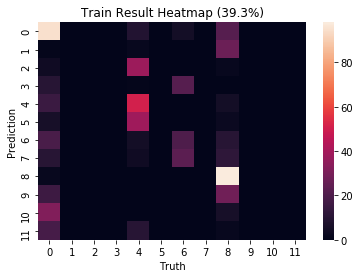

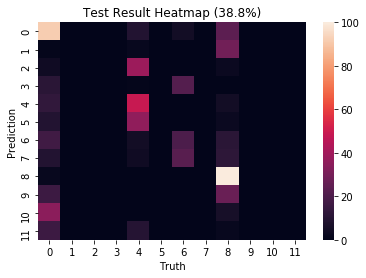

In [8]:
print('Network with synapse:')

network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


network.add_layer(DenseWithSynapse,
    input_shape=(64, 64),
    output_shape=128,
    w_init_mean=0.0,
    w_init_std=weight_scale
)

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!


# opt = RAdam(network.get_trainable_parameters())
opt = torch.optim.SGD(network.get_trainable_parameters(), lr=1e-3, momentum=0.9)
network.fit(load_data, epochs=nb_epochs, optimizer=opt, dataset_size=dataset_size)

print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'))

Network without synapse:
[expecting to finish at 2020-04-22 12:38:21]
Epoch: 0 [===========================================================>] 100%      | loss=2.483 val_loss=2.481
train_accuracy=19.05%  |  valid_accuracy=19.35%
[operation finished at 2020-04-22 12:36:30  -  took 14 seconds]
[expecting to finish at 2020-04-22 12:38:25]
Epoch: 1 [===========================================================>] 100%      | loss=2.479 val_loss=2.476
train_accuracy=19.35%  |  valid_accuracy=18.60%
[operation finished at 2020-04-22 12:36:45  -  took 14 seconds]
[expecting to finish at 2020-04-22 12:38:28]
Epoch: 2 [===========================================================>] 100%      | loss=2.475 val_loss=2.472
train_accuracy=19.49%  |  valid_accuracy=19.49%
[operation finished at 2020-04-22 12:37:00  -  took 14 seconds]
[expecting to finish at 2020-04-22 12:38:32]
Epoch: 3 [===========================================================>] 100%      | loss=2.470 val_loss=2.468
train_accuracy=19.4

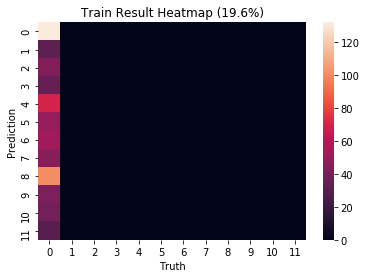

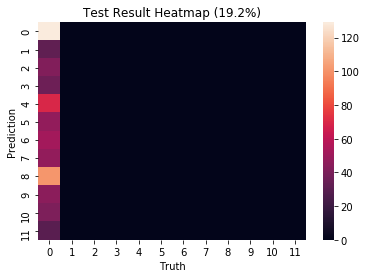

In [9]:
print('Network without synapse:')

network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


network.add_layer(DenseWithoutSynapse,
    input_shape=(64, 64),
    output_shape=128,
    w_init_mean=0.0,
    w_init_std=weight_scale
)

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!


# opt = RAdam(network.get_trainable_parameters())
opt = torch.optim.SGD(network.get_trainable_parameters(), lr=1e-3, momentum=0.9)
network.fit(load_data, epochs=nb_epochs, optimizer=opt, dataset_size=dataset_size)

print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'))